# KDE

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

http://shogun-toolbox.org/notebook/latest/KernelDensity.html

In [1]:
%matplotlib inline
from dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings

warnings.simplefilter(action='ignore')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# pdf function for plotting
n_samples = 100
x_min = 0.001
x_max = 15

# parameters of the distribution
mu1 = 4
sigma1 = 1
mu2 = 8
sigma2 = 2

# Parameters of the KDE
bandwidth = 0.5

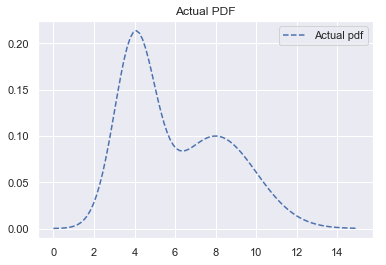

In [3]:
x = np.linspace(x_min, x_max, n_samples)
y = 0.5*(stats.norm(mu1, sigma1).pdf(x)+stats.norm(mu2, sigma2).pdf(x))

# plot actual pdf
plt.plot(x, y, 'b--', label="Actual pdf")
plt.legend(numpoints=1)
plt.title('Actual PDF')
plt.show();

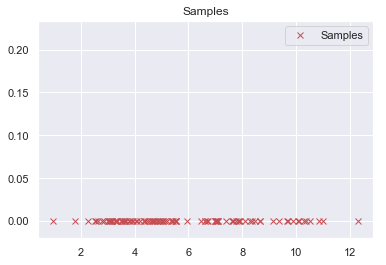

In [4]:
def generate_samples(n_samples, mu1, sigma1, mu2, sigma2):
    samples1 = np.random.normal(mu1, sigma1, (1, int(n_samples/2)))
    samples2 = np.random.normal(mu2, sigma2, (1, int(n_samples/2)))
    samples = np.concatenate((samples1, samples2), 1)
    return samples

samples = generate_samples(n_samples, mu1, sigma1, mu2, sigma2)
samples = samples.T

# plot samples
plt.plot(samples, np.zeros(n_samples), 'rx', label="Samples")
plt.legend(numpoints=1)
plt.title('Samples')
plt.ylim(-0.02, max(y)+0.02)
plt.show()

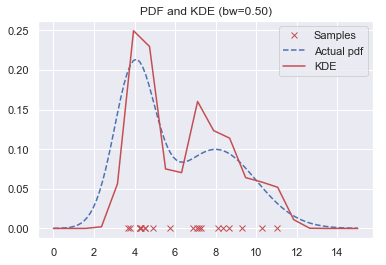

In [5]:
# Generate more samples
n_samples = 20
samples = generate_samples(n_samples, mu1, sigma1, mu2, sigma2)
samples = samples.T

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(samples)

# score_samples returns the log of the probability density
x_d = np.linspace(x_min, x_max, n_samples).reshape(-1, 1)
logprob = kde.score_samples(x_d)

plt.plot(samples, np.zeros(n_samples), 'rx', label='Samples')
plt.plot(x, y, 'b--', label="Actual pdf")
plt.plot(x_d, np.exp(logprob), 'r-', label='KDE')
plt.legend()
plt.title('PDF and KDE (bw={:.2f})'.format(bandwidth))
plt.show();

In [6]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);
bandwidth = grid.best_params_['bandwidth']
print('Optimal Bandwidth: {:.2f}'.format(bandwidth))

Optimal Bandwidth: 1.02


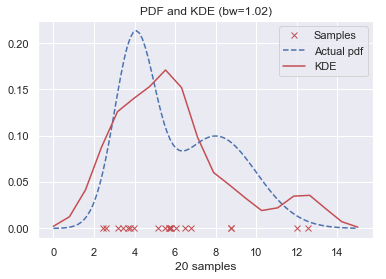

In [7]:
# Generate samples
n_samples = 20
samples = generate_samples(n_samples, mu1, sigma1, mu2, sigma2)
samples = samples.T

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(samples)

# score_samples returns the log of the probability density
x_d = np.linspace(x_min, x_max, n_samples).reshape(-1, 1)
logprob = kde.score_samples(x_d)

# plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(samples, np.zeros(n_samples), 'rx', label='Samples')
plt.plot(x, y, 'b--', label="Actual pdf")
plt.plot(x_d, np.exp(logprob), 'r-', label='KDE')
plt.legend()
plt.title('PDF and KDE (bw={:.2f})'.format(bandwidth))
plt.xlabel('20 samples')
plt.show();

Effect on the number of samples used to fit the KDE. Let's jump from 20 to 200, with same bandwidth.

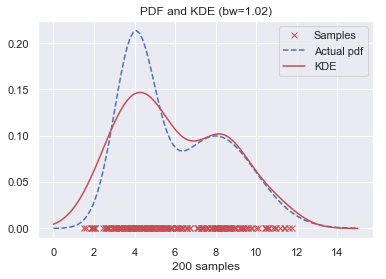

In [8]:
# Generate more samples
n_samples = 200
samples = generate_samples(n_samples, mu1, sigma1, mu2, sigma2)
samples = samples.T

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(samples)

# score_samples returns the log of the probability density
x_d = np.linspace(x_min, x_max, n_samples).reshape(-1, 1)
logprob = kde.score_samples(x_d)

# plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(samples, np.zeros(n_samples), 'rx', label='Samples')
plt.plot(x, y, 'b--', label="Actual pdf")
plt.plot(x_d, np.exp(logprob), 'r-', label='KDE')
plt.legend()
plt.title('PDF and KDE (bw={:.2f})'.format(bandwidth))
plt.xlabel('200 samples')
plt.show();

## KDE Classifier over HR dataset

Mostly from [here](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb)

The general approach for **generative classification** is this:

1. Split the training data by label.
2. For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x~|~y)$.
3. From the number of examples of each class in the training set, compute the class prior, $P(y)$.
4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$. The class which maximizes this posterior is the label assigned to the point.

The algorithm is straightforward and intuitive to understand; the more difficult piece is couching it within the Scikit-Learn framework in order to make use of the grid search and cross-validation architecture.

### Load the HR dataset

Perform basic transformation over the features. We will only use numerical features.

In [9]:
hr = Dataset('./data/hr-analytics.zip')
hr.set_target('left')
hr.to_categorical(['number_project', 'time_spend_company',
                   'promotion_last_5years', 'Work_accident'])
hr.scale()
hr.summary('numerical')


Features Summary (numerical):
'satisfaction_level'  : float64    Min.(-2.1) 1stQ(-0.6) Med.(0.10) Mean(-1.7) 3rdQ(0.83) Max.(1.55)
'last_evaluation'     : float64    Min.(-2.0) 1stQ(-0.9) Med.(0.02) Mean(-4.2) 3rdQ(0.89) Max.(1.65)
'average_montly_hours': float64    Min.(-2.1) 1stQ(-0.9) Med.(-0.0) Mean(-4.9) 3rdQ(0.88) Max.(2.18)


In [10]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [11]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

bandwidths = 10 ** np.linspace(-1, 0, 10)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths},
                   scoring='accuracy')
grid.fit(hr.select('numerical'), hr.target)
scores = grid.cv_results_['mean_test_score']

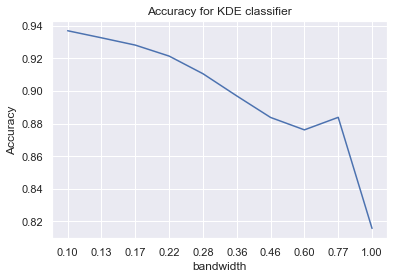

In [12]:
plt.plot(scores)
plt.title('Accuracy for KDE classifier')
plt.ylabel('Accuracy')
plt.xlabel('bandwidth')
plt.xticks(np.arange(len(bandwidths)), ['{:.2f}'.format(b) for b in bandwidths])
plt.show()

We see that this not-so-naive Bayesian KDE classifier reaches a cross-validation accuracy of just over 93%; this is compared to around 76% for the naive Bayesian classification:

In [14]:
cross_val_score(GaussianNB(), hr.select('numerical'), hr.target).mean()

0.7640506172286914